In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

import scipy.stats as stats

pd.pandas.set_option('display.max_columns',None)

In [2]:
data = pd.read_csv('campaign.csv')

print(data.shape)

data.head()

(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [3]:
data.drop('ID',axis=1,inplace=True)
data.shape

(2240, 28)

## Target

Let's begin by exploring the distributions of the target labels.

<AxesSubplot:xlabel='Response', ylabel='count'>

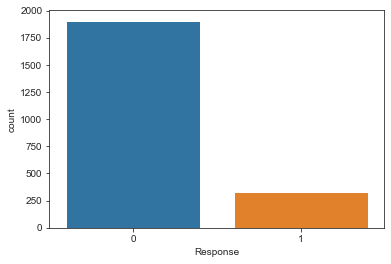

In [4]:
sns.countplot(x='Response',data=data)

In [5]:
yes = data[data['Response']==1]
no = data[data['Response']==0]

yes_perc = len(yes) / len(data)
no_perc = len(no) / len(data)

ratio = len(no) / len(yes)

print(f'Number of YES responses: {len(yes)}')
print(f'Number of NO responses: {len(no)}')
print()

print(f'Perc of YES responses: {yes_perc}')
print(f'Perc of NO responses: {no_perc}')
print()

print(f'Ratio of NO to YES: {ratio}')

Number of YES responses: 334
Number of NO responses: 1906

Perc of YES responses: 0.14910714285714285
Perc of NO responses: 0.8508928571428571

Ratio of NO to YES: 5.706586826347305


A few things we notice from the plot:

- We can tell either the the campaign wasn't very successful or effective given the number of YES responses compared to the NO responses or...
- We don't have sufficient data on the positive responses to the campaign for reasons unknown to us.
- Because of the low number of positive responses, we don't have a lot of 'Yes' responses for our model to train on.
- As such, we can expect the model to be more familiar with positive responses than negative responses which negates the business need for the model in the first place.

## Variable Types

Let's identify the categorical and numerical variables

In [6]:
# let's identify the categorical variables
# we will capture those of type *object*
cat_vars = [var for var in data.columns if data[var].dtype=='O']

# number of categorical variables
len(cat_vars)

3

In [7]:
# print out the categorical variables
cat_vars

['Education', 'Marital_Status', 'Dt_Customer']

In [8]:
data[cat_vars].head()

,Education,Marital_Status,Dt_Customer
0,Graduation,Single,2012-09-04
1,Graduation,Single,2014-03-08
2,Graduation,Together,2013-08-21
3,Graduation,Together,2014-02-10
4,PhD,Married,2014-01-19


In [9]:
# now let's identify the numerical variables
num_vars = [var for var in data.columns if var not in cat_vars and var != 'Response']

# number of numerical variables
len(num_vars)

24

In [10]:
data[num_vars].head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue
0,1957,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11
1,1954,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11
2,1965,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11
3,1984,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11
4,1981,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11


# Missing Values

Let's go ahead and find out which variables of the dataset contain missing values.

In [11]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data
data[vars_with_na].isnull().mean().sort_values(ascending=False)

Income    0.010714
dtype: float64

We have only one variable with missing values. At just 1% of the entire dataset, it is only a small proportion.

Null values aren't always the only placeholders for missing values. They could also be represented with different string objects that indicate data is missing, particularly for categorical variables. To find these, we can loop through all the categorical columns, grab the unique values and identify and value suggesting data is missing.

In [12]:
for col in cat_vars:
    print(f'{col}: {data[col].unique()}')

Education: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Marital_Status: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
Dt_Customer: ['2012-09-04' '2014-03-08' '2013-08-21' '2014-02-10' '2014-01-19'
 '2013-09-09' '2012-11-13' '2013-05-08' '2013-06-06' '2014-03-13'
 '2013-11-15' '2012-10-10' '2012-11-24' '2012-12-24' '2012-08-31'
 '2013-03-28' '2012-11-03' '2012-08-08' '2013-01-06' '2012-12-23'
 '2014-01-11' '2013-03-18' '2013-01-02' '2013-05-27' '2013-02-20'
 '2013-05-31' '2013-11-22' '2014-05-22' '2013-05-11' '2012-10-29'
 '2013-08-29' '2013-12-31' '2013-09-02' '2014-02-11' '2013-02-01'
 '2013-04-29' '2013-03-12' '2013-11-05' '2013-10-02' '2014-06-28'
 '2012-11-09' '2013-05-24' '2014-01-01' '2012-11-08' '2014-05-12'
 '2012-08-11' '2014-06-07' '2013-06-12' '2012-11-19' '2013-04-02'
 '2014-04-28' '2013-06-17' '2014-03-03' '2013-07-04' '2012-09-07'
 '2013-02-18' '2013-06-11' '2013-12-06' '2013-05-21' '2014-05-11'
 '2014-03-19' '2013-09-27' '2013-04-08' '201

None of the categorical variables seem to have and string objects that might suggest missing or incomplete data.

To find missing values in our numerical variables, we will loop through each of them to find values that aren't of type integer or float.

In [13]:
for col in num_vars:
    for value in data[col]:
        if type(value) != data[col].dtype:
            print(col)

There are no missing values in the numerical variables.

## Relationship between missing data and target label

Let's evaluate the responses in those observations (i.e. Income) where information is missing.

<AxesSubplot:xlabel='Income', ylabel='count'>

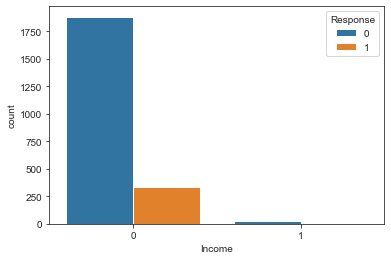

In [14]:
# copy of the dataframe so we don't override the original
tmp = data.copy()

# convert the income variable to a binary variable
# 1: rows with null value
# 2: rows with available information
tmp['Income'] = np.where(tmp['Income'].isnull(), 1, 0)

# compare response rates in obs where data is missing
# vs the obs where data is available
sns.countplot(x='Income',data=tmp,hue='Response')

In [15]:
for label in tmp['Income'].unique():
    
    num_of_y_in_label = tmp[(tmp['Income']==label) & (tmp['Response']==1)]
    label_count = tmp[tmp['Income']==label]
    perc_of_y = len(num_of_y_in_label) / len(label_count)
    
    print(f'Perc of yes responses in Income label {label}: {perc_of_y}')
    print()

Perc of yes responses in Income label 0: 0.15027075812274368

Perc of yes responses in Income label 1: 0.041666666666666664



Both missing and available classes have low rates of positive responses. It would still take an hypothesis test to determine if missing value was indicative of campaign response and if the differences in response rates between the two labels were statistically significant.

Given its small percentage of the dataset and the tiny fraction of positive cases across both classes, however, it is unlikely for missing data to be a good predictor of responses.

# Numerical Variables

Let's go ahead and find out what numerical variables we have in the dataset.

In [16]:
print(f'Number of numerical variables: {len(num_vars)}')

# visualise the numerical variables
data[num_vars].head()

Number of numerical variables: 24


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue
0,1957,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11
1,1954,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11
2,1965,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11
3,1984,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11
4,1981,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11


## Temporal Variables

There are 2 year variables in the dataset - Dt_Customer and Year_Birth. While Year_Birth is recorded as a numerical variables, Dt_Customer is recorded as categorical.

We will convert both variables to indicate/reflect customer age and patronage period.

### Dt_Customer

In [17]:
data['Dt_Customer'].head()

0    2012-09-04
1    2014-03-08
2    2013-08-21
3    2014-02-10
4    2014-01-19
Name: Dt_Customer, dtype: object

In [18]:
# grab the year from the date
# convert the year to int from str
def adjust_date(row):
    
    return int(row.split('-')[0])

In [19]:
data['Dt_Customer'] = data['Dt_Customer'].apply(adjust_date)
data['Dt_Customer'].head()

0    2012
1    2014
2    2013
3    2014
4    2014
Name: Dt_Customer, dtype: int64

In [20]:
# subtract the year from 2022 to get the patronage period
data['Dt_Customer'] = 2022 - data['Dt_Customer']
data['Dt_Customer'].head()

0    10
1     8
2     9
3     8
4     8
Name: Dt_Customer, dtype: int64

### Year_Birth

In [21]:
data['Year_Birth'].head()

0    1957
1    1954
2    1965
3    1984
4    1981
Name: Year_Birth, dtype: int64

In [22]:
# subtract the year from 2022 to get customer age
data['Year_Birth'] = 2022 - data['Year_Birth']
data['Year_Birth'].head()

0    65
1    68
2    57
3    38
4    41
Name: Year_Birth, dtype: int64

In [23]:
# add patronage period to numerical variables
num_vars = num_vars + ['Dt_Customer']
num_vars

['Year_Birth',
 'Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Z_CostContact',
 'Z_Revenue',
 'Dt_Customer']

### Discrete Variables

Let's go ahead and find which variables are discrete, i.e., show a finite number of values.

In [24]:
# list out the discrete variable
discrete_vars = [var for var in num_vars if len(
    data[var].unique()) < 20]
print(f'Number of discrete variables: {len(discrete_vars)}')

Number of discrete variables: 16


In [25]:
# print out the number of unique value per variable
for var in discrete_vars:
    print(f'{var}: {data[var].nunique()}')

Kidhome: 3
Teenhome: 3
NumDealsPurchases: 15
NumWebPurchases: 15
NumCatalogPurchases: 14
NumStorePurchases: 14
NumWebVisitsMonth: 16
AcceptedCmp3: 2
AcceptedCmp4: 2
AcceptedCmp5: 2
AcceptedCmp1: 2
AcceptedCmp2: 2
Complain: 2
Z_CostContact: 1
Z_Revenue: 1
Dt_Customer: 3


Z_CostContact and Z_Revenue have constant values so we can go ahead and drop them.

In [26]:
data[['Z_CostContact','Z_Revenue']].head()

,Z_CostContact,Z_Revenue
0,3,11
1,3,11
2,3,11
3,3,11
4,3,11


In [27]:
data = data.drop(['Z_CostContact','Z_Revenue'],axis=1)

In [28]:
# updated list of discrete variables

discrete_vars = ['Kidhome',
 'Teenhome',
 'NumDealsPurchases',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'NumWebVisitsMonth',
 'AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Complain',
 'Dt_Customer']

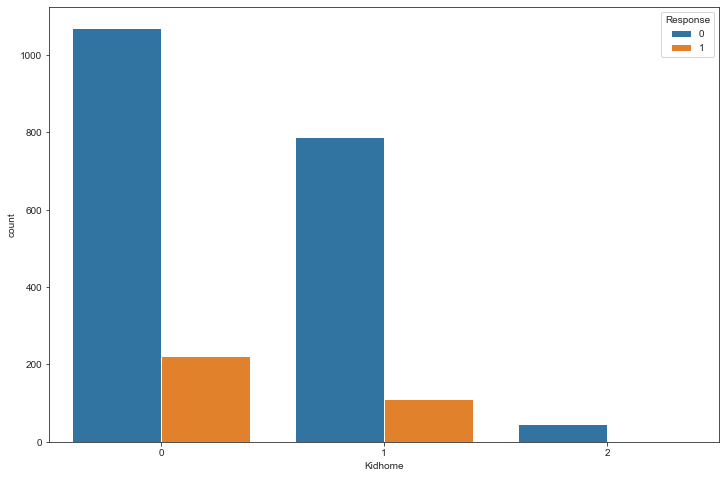

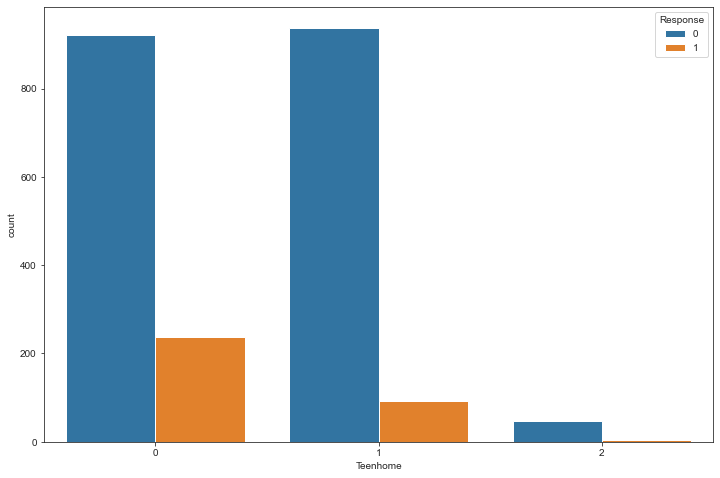

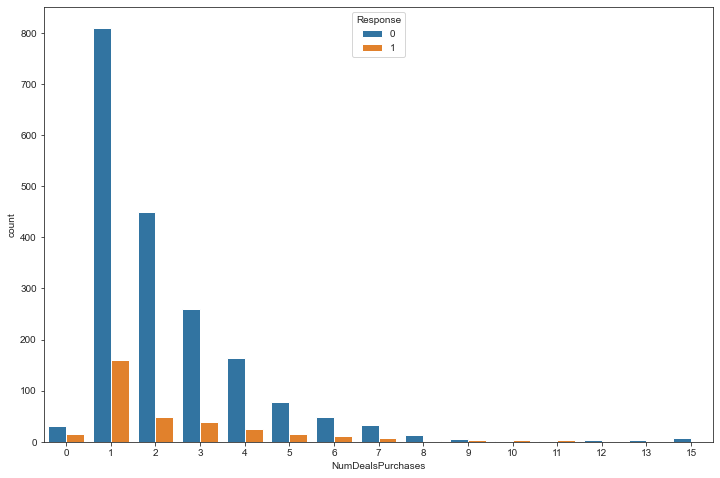

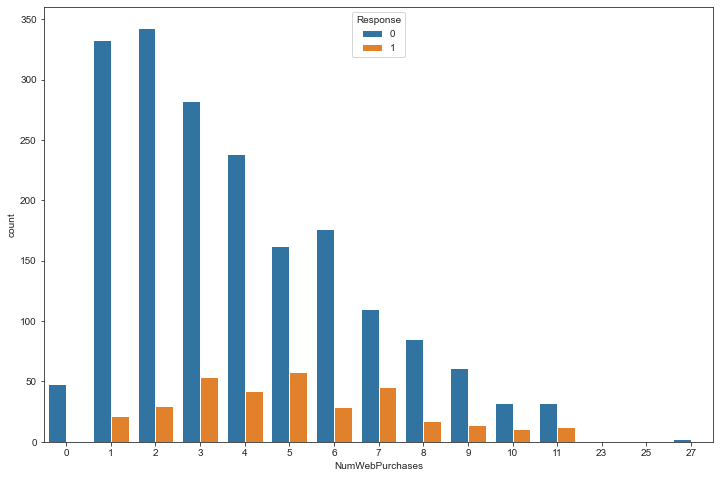

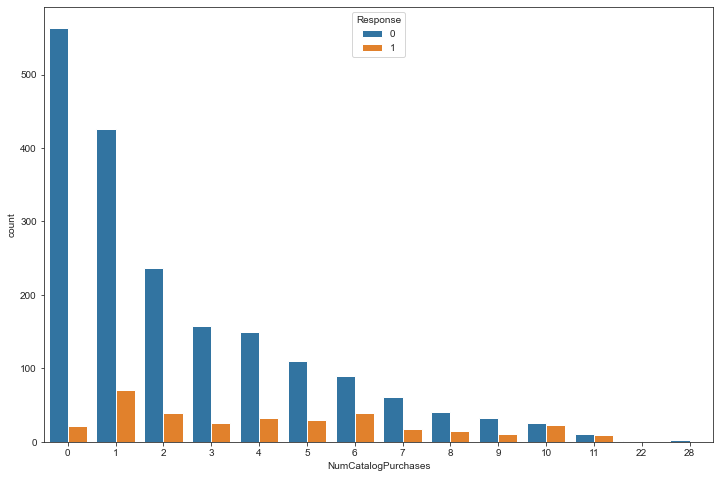

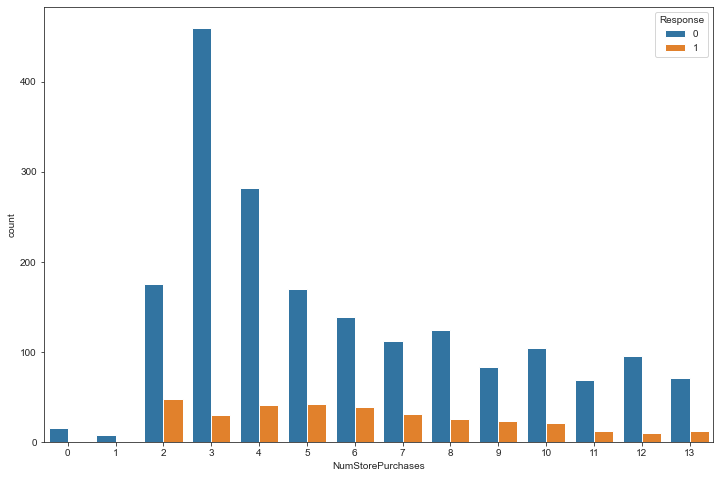

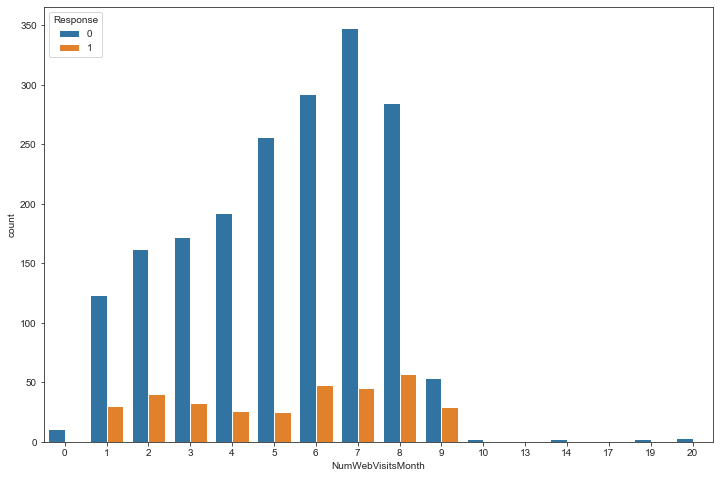

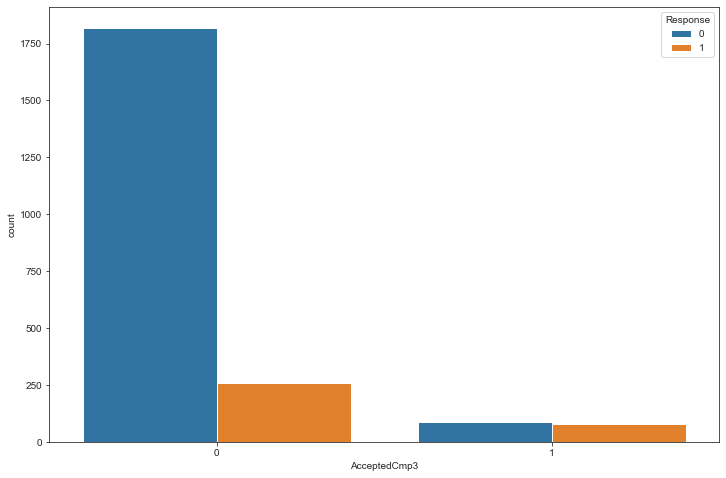

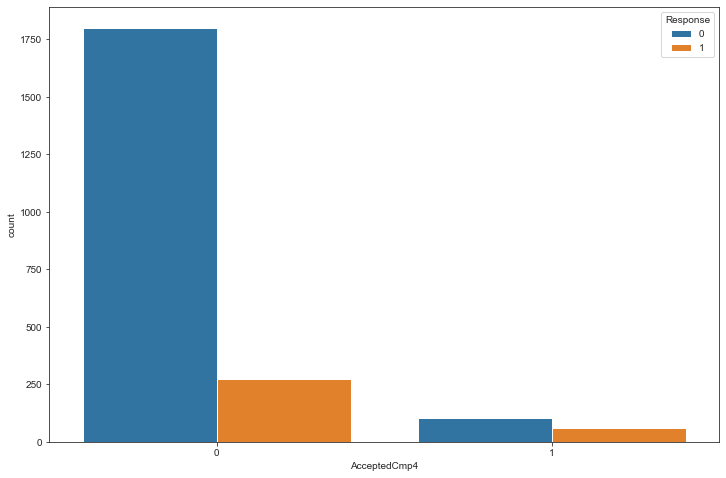

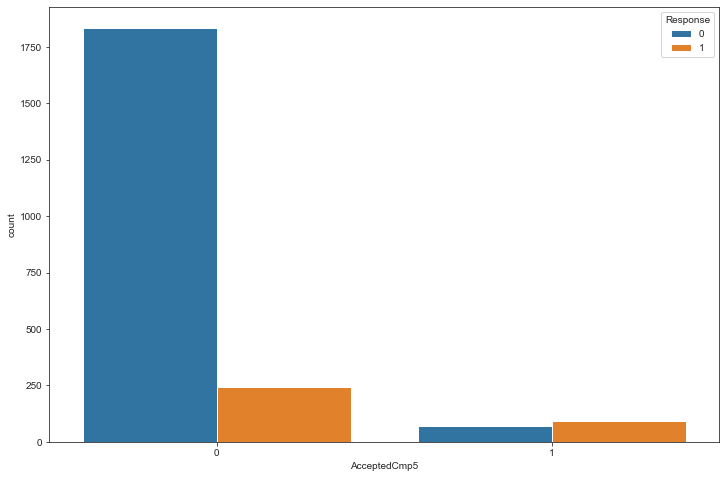

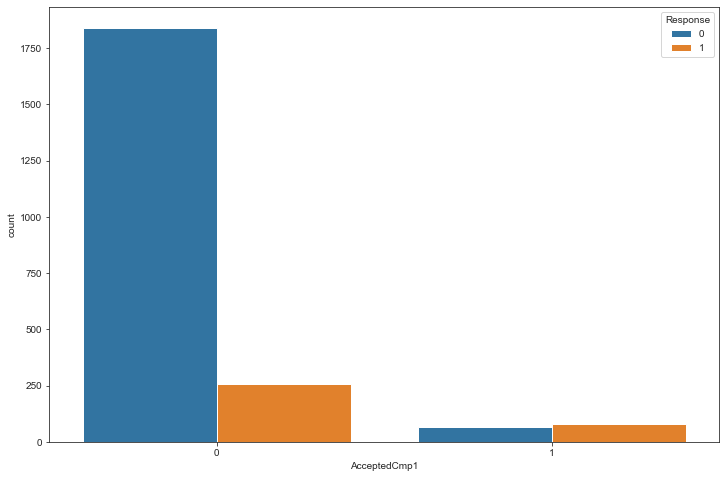

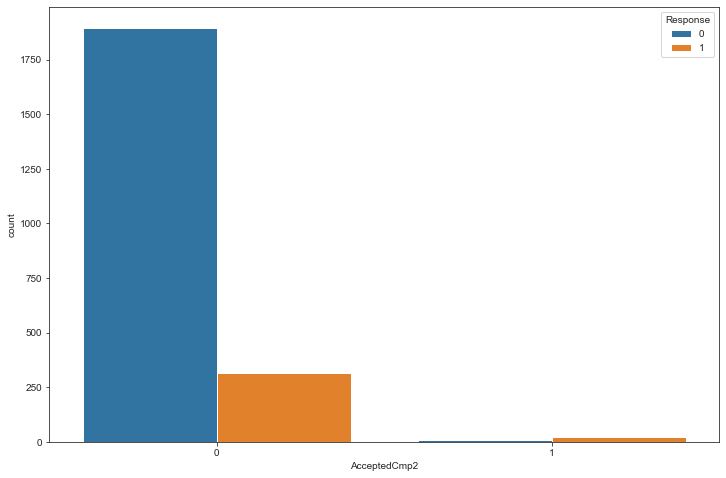

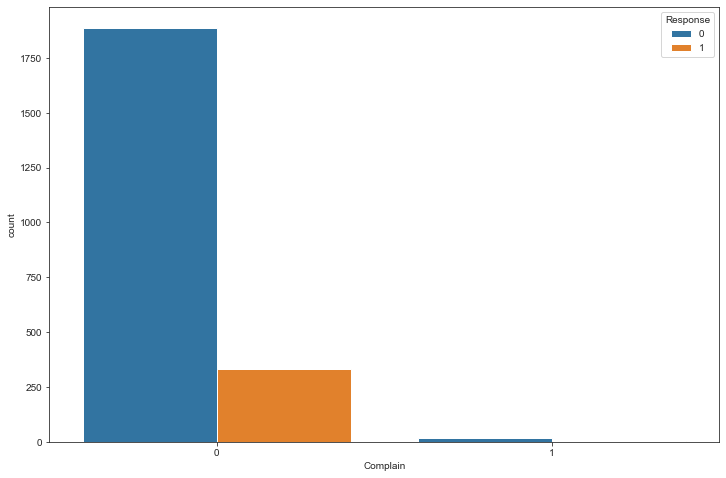

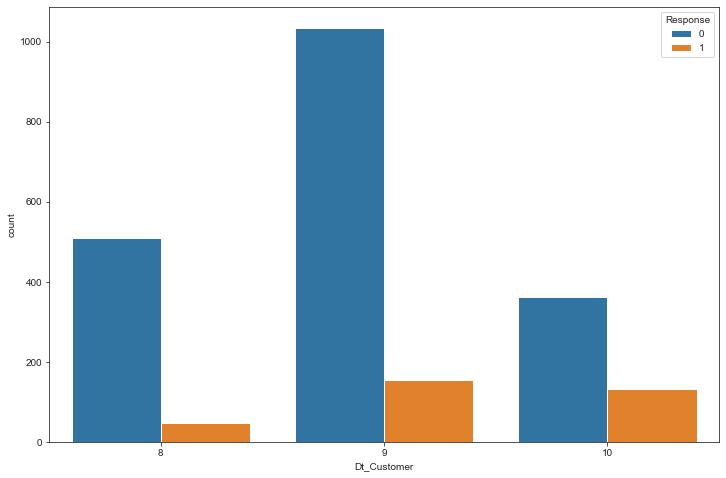

In [29]:
# countplots of discrete variables
for var in discrete_vars:
    plt.figure(figsize=(12,8))
    sns.countplot(x=var, data=data, hue='Response')
    plt.show()

- Notice the negative relationship between customer counts and the number of purchases across the various platforms.
- There are a lot of web visits that don't nessecarily translate into web purchasing activity.
- We have a lot of values with low counts across the various buying platforms. It is also at these low values we start to notice parity between positive and negative responses which might suggest association between buying behaviour and campaign response.
- There are high positive response rates with customers who have participated in previous campaigns.


## Continuous Variables

Let's go ahead and find the distribution of the continuous variables. We will consider continuous variables to all those that are not discrete.

In [30]:
# make list of continuous variables
cont_vars = [var for var in num_vars if var not in discrete_vars
            and var not in ['Z_CostContact','Z_Revenue']]

print(f'Number of continuous variables: {len(cont_vars)}')

Number of continuous variables: 9


In [31]:
# visualise the continuous variables
data[cont_vars].head()

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,65,58138.0,58,635,88,546,172,88,88
1,68,46344.0,38,11,1,6,2,1,6
2,57,71613.0,26,426,49,127,111,21,42
3,38,26646.0,26,11,4,20,10,3,5
4,41,58293.0,94,173,43,118,46,27,15


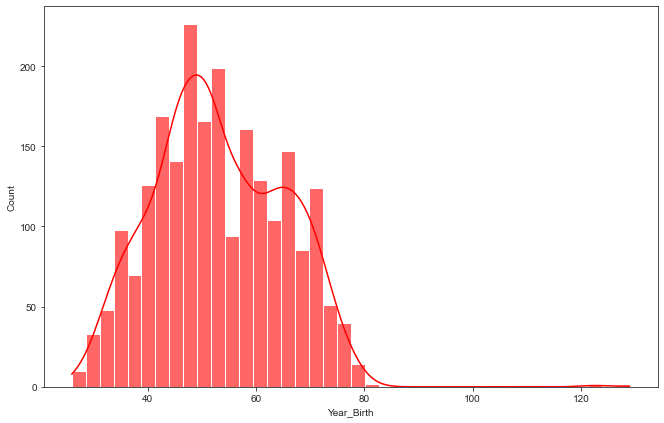

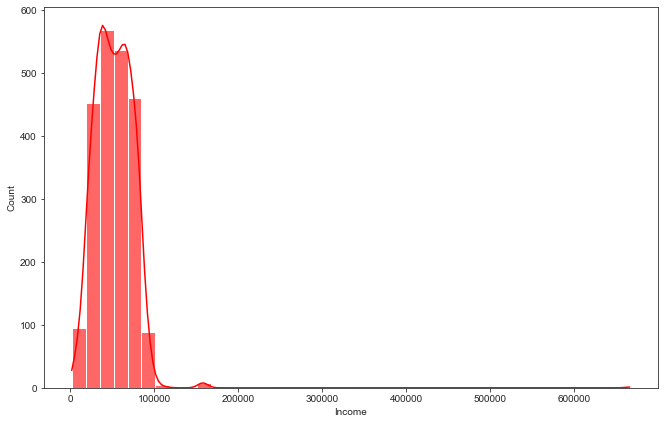

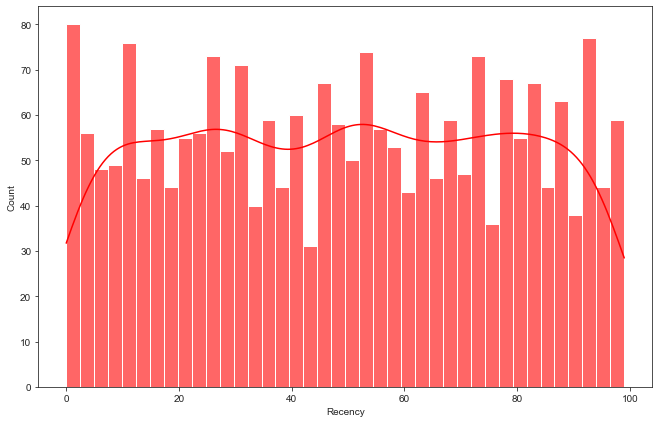

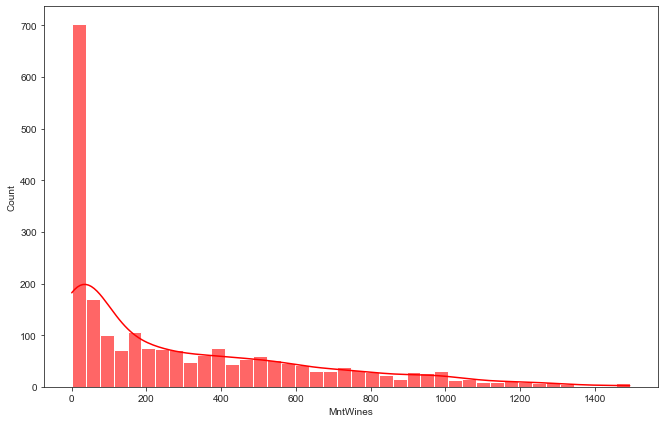

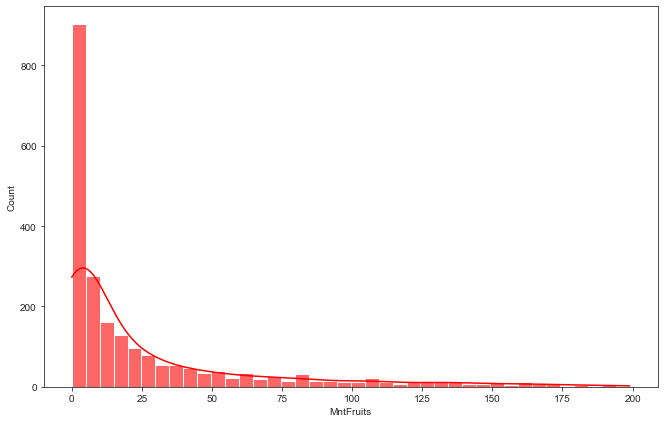

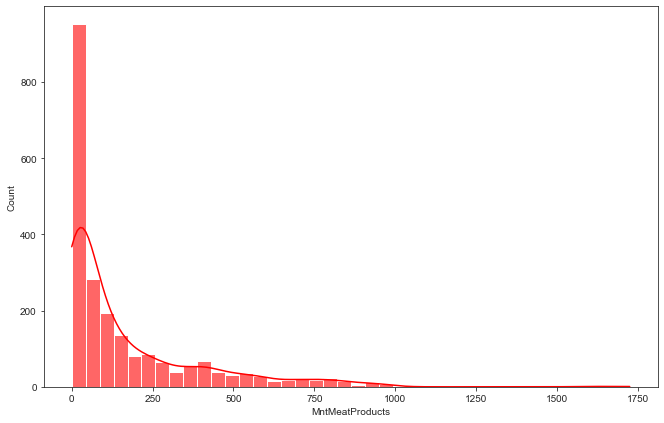

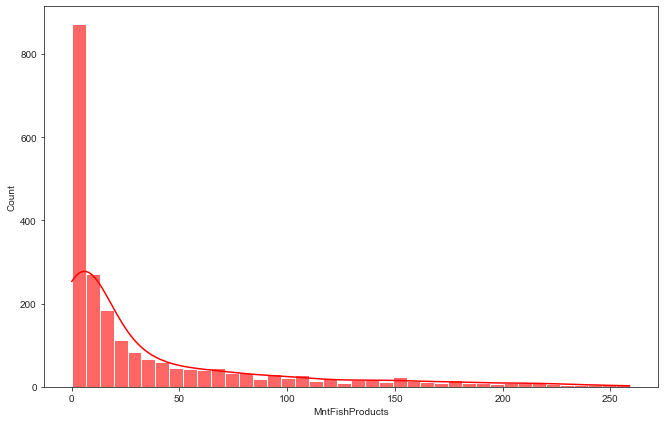

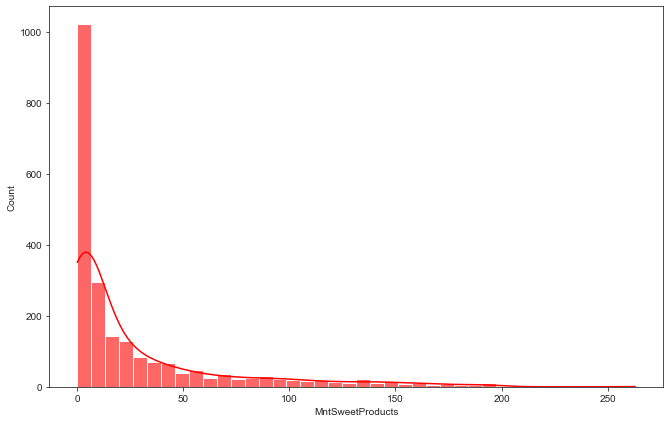

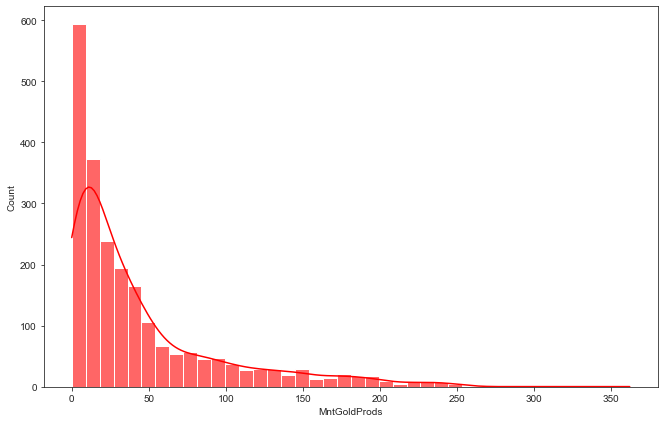

In [32]:
# let's plot instagrams for all continuous variables
for var in cont_vars:
    plt.figure(figsize=(11,7))
    sns.histplot(x=var, data=data, color='red', alpha=0.6, bins=40, kde=True)

Besides the ages and the Income variables, none of the other variables are normally distributed. 

The age and income variables also seem to have outliers that might impact our analysis:
- We have a 129 year-old customer.
- There is also a customer with a 666,666 salary which seems far outside the range of salaries in the column.

In [33]:
data[['Year_Birth','Income']].describe()

,Year_Birth,Income
count,2240.000000,2216.000000
mean,53.194196,52247.251354
std,11.984069,25173.076661
min,26.000000,1730.000000
25%,45.000000,35303.000000
50%,52.000000,51381.500000
75%,63.000000,68522.000000
max,129.000000,666666.000000


We will take out both values from the dataframe.

### Year_Birth

The least outlier value for age is 122. We will set any value larger than 122 (i.e. all outliers) equal to the highest value covered by the range of the distribution.

In [34]:
# compute the highest age value excluding the outliers
max_age = data[data['Year_Birth']<122]['Year_Birth'].max()
max_age

82

In [35]:
# set the outliers to the maximum age
data['Year_Birth'] = np.where(data['Year_Birth']>max_age,max_age,data['Year_Birth'])

In [36]:
data['Year_Birth'].max()

82

### Income
Just like Year_Birth, we set outlier values to the highest value in the variable excluding the outliers.

In [37]:
# find the max income value outside the outliers
max_income = data[data['Income']!=data['Income'].max()]['Income'].max()
max_income

162397.0

In [39]:
# set the outliers to the maximum value
data['Income'] = np.where(data['Income']>max_income,max_income,data['Income'])
max_income

162397.0

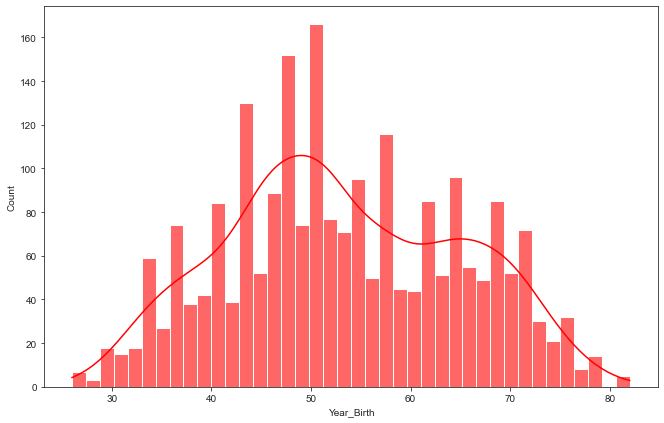

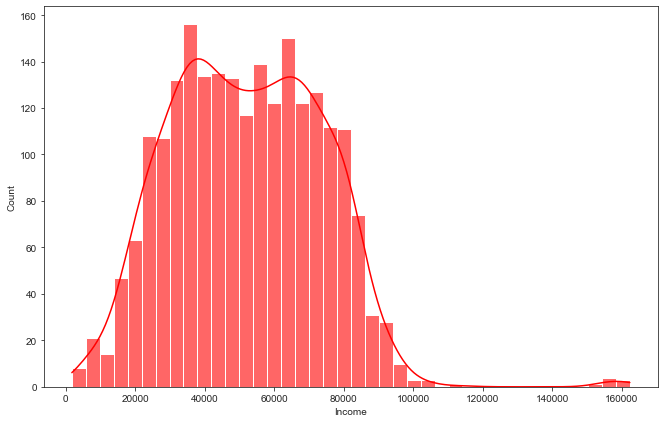

In [40]:
# re-plot the distributions of the adjusted variables
for var in ['Year_Birth','Income']:
    plt.figure(figsize=(11,7))
    sns.histplot(x=var, data=data, color='red', alpha=0.6, bins=40, kde=True)

We will now re-plot the distributions of all the continuous variables based on their campaign responses (i.e. the target label).

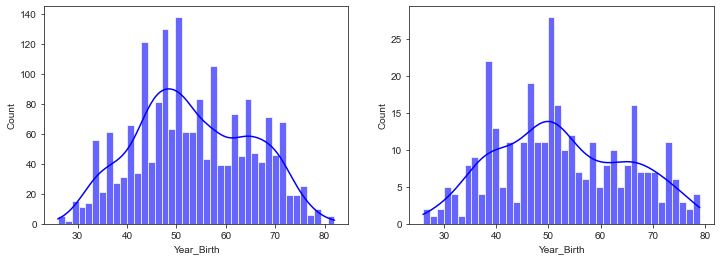

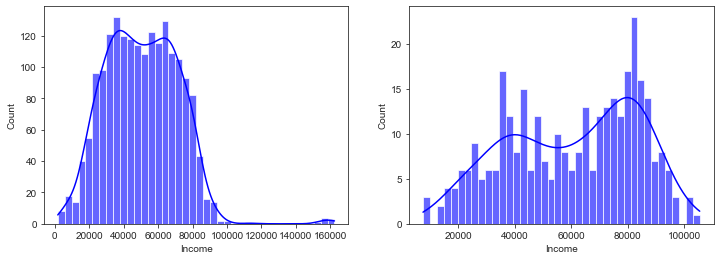

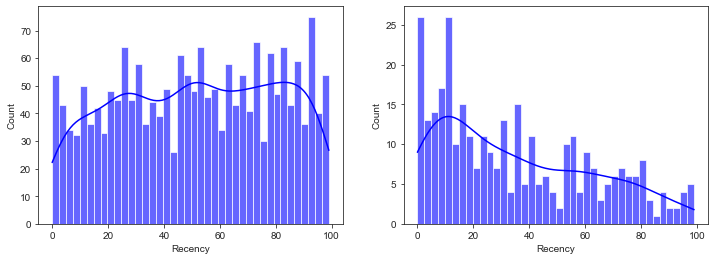

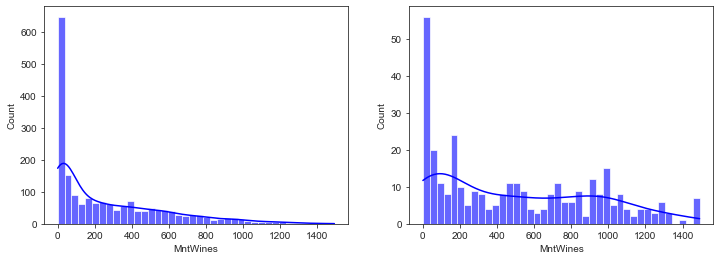

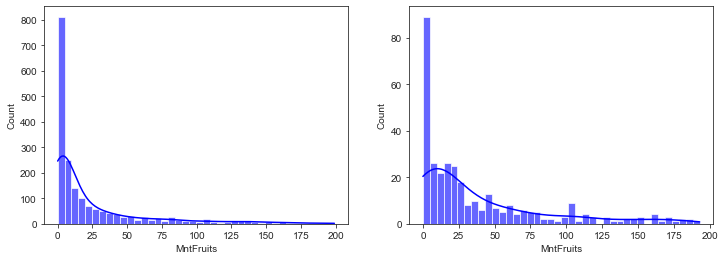

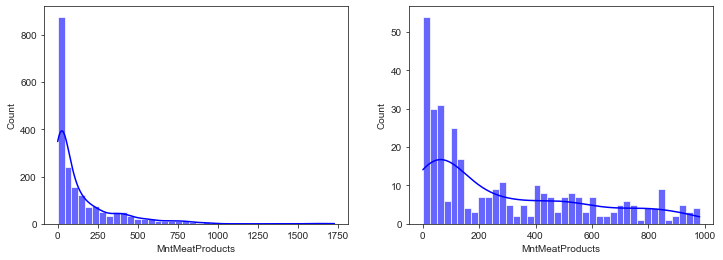

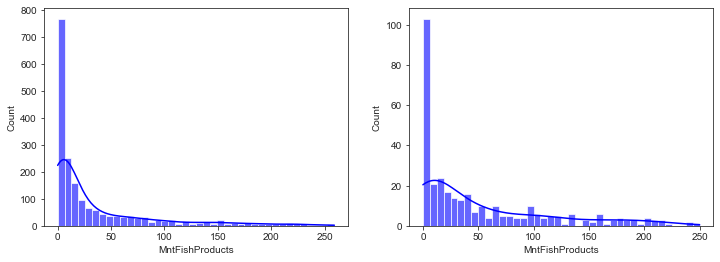

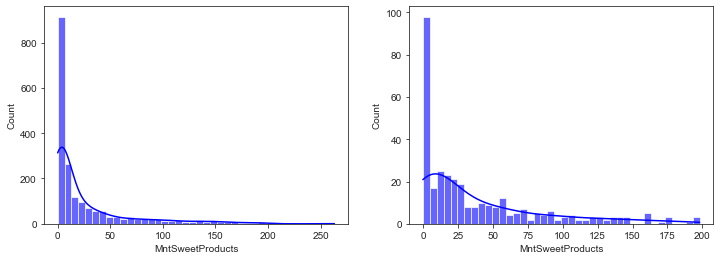

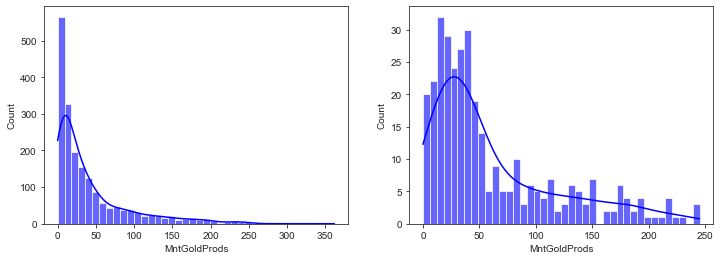

In [41]:
for var in cont_vars:
    
    plt.figure(figsize=(12,4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(x=var, data=data[data['Response']==0], color='blue', alpha=0.6, bins=40, kde=True)
    plt.xlabel(var)
    
    plt.subplot(1, 2, 2)
    sns.histplot(x=var, data=data[data['Response']==1], color='blue', alpha=0.6, bins=40, kde=True)
    plt.xlabel(var)
    
    plt.show()

The distributions all seem to fall within the same ranges so it's hard to notice any differences with just an eye-test. This suggests effect sizes might not be considerable even if p-values suggest a statistical difference in the means.

# Categorical Variables

Let's go ahead and analyse the categorical variables present in the dataset.

In [42]:
print(f'Number of categorical variables: {len(cat_vars)}')

Number of categorical variables: 3


In [45]:
cat_vars = ['Education', 'Marital_Status']

In [46]:
data[cat_vars].head()

,Education,Marital_Status
0,Graduation,Single
1,Graduation,Single
2,Graduation,Together
3,Graduation,Together
4,PhD,Married


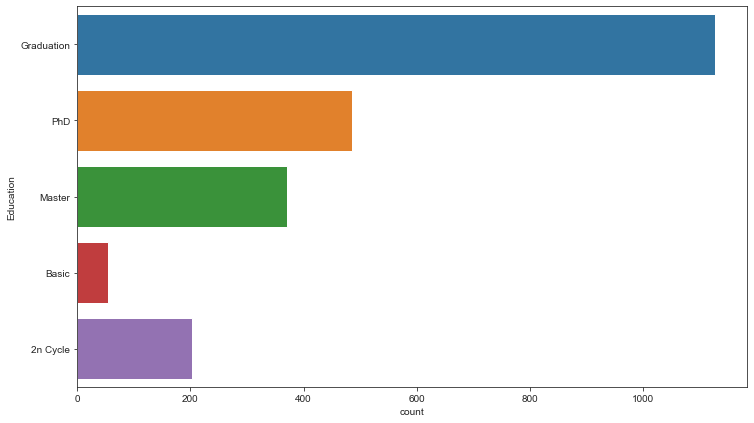

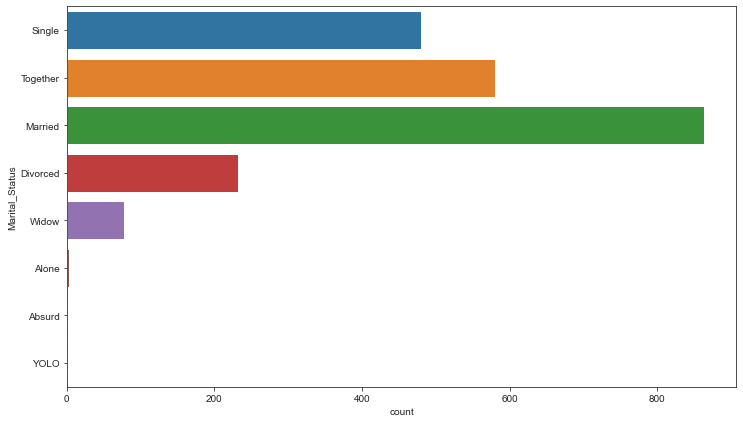

In [47]:
for var in cat_vars:
    plt.figure(figsize=(12,7))
    sns.countplot(y=var, data=data)
    plt.show()

Let's divide the countplots per campaign response.

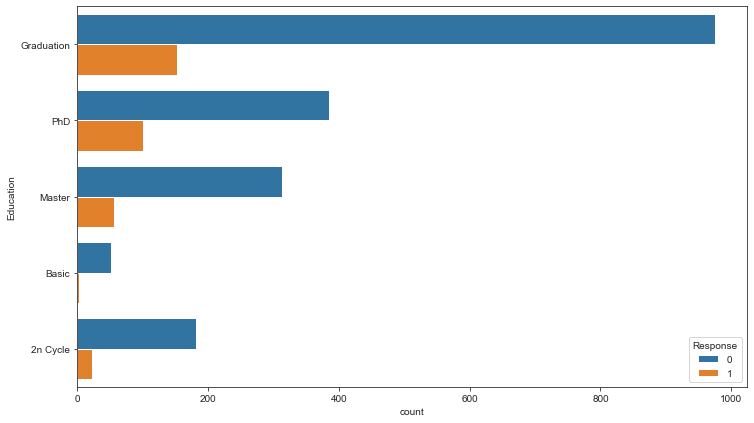

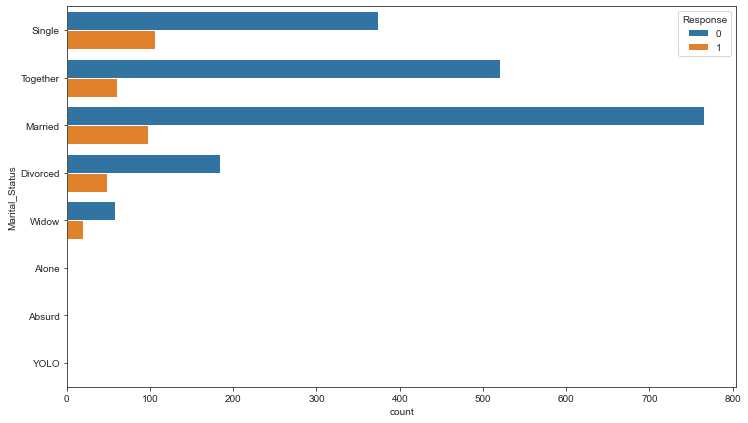

In [49]:
for var in cat_vars:
    plt.figure(figsize=(12,7))
    sns.countplot(y=var, data=data, hue='Response')
    plt.show()

Just like the other variable types, we notice negative responses dominating the labels. It is important to note that classification results/metrics for undersized labels and values would have to be intepreted with caution because we aren't sure of the model's familiarity with them.

## Number of labels: cardinality

Let's evaluate how many different categories are present in each of the categorical variables.

<AxesSubplot:>

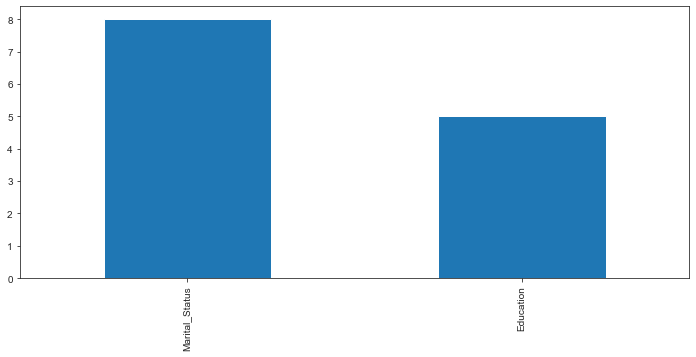

In [50]:
data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

The two variables show low cardinality, i.e. they have only few different labels. This is good as we won't need to tackle cardinality during feature engineering.

In conclusion, over-familiarity with the positive class and the lack of a visible difference in distributions between labels/values across the variables might result in an inefficient model. A lot of the 'differences' tends to be seen in variable values that are undersampled in the dataset.